In [1]:
import numpy as np
import pandas as pd

import os.path
from os import listdir
import subprocess
import time
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def members(new_ids = 'yes'):
    """
    Read and parse the info for the members file (smallint, dates, ...)
    """
    members_file = pd.read_csv('../new_members.csv', dtype={
            'bd': np.int8, 'city': np.int8, 'gender':'category' ,
            'registered_via':np.int8, 'registration_init_time':'str',
            'expiration_date': 'str', 'new_id':np.uint32},
                parse_dates=['expiration_date', 'registration_init_time'])

    return members_file

def transactions(new_ids = 'yes'):
    """
    Read and parse the info for the txn file (smallint, dates, ...)
    """
    txn_file = pd.read_csv('../new_transactions.csv', dtype={
        'payment_method_id': np.int8,
        'payment_plan_days': np.uint16,
        'is_cancel': np.int8,
        'is_auto_renew': np.int8,
        'transaction_date': 'str',
        'membership_expire_date': 'str',
        'plan_list_price': np.uint16,
        'actual_amount_paid': np.uint16,
        'new_id': np.uint32},
        parse_dates=['transaction_date', 'membership_expire_date'])

    return txn_file

def train(new_ids = 'yes'):
    """
    Read and parse the info for the train file (smallint, dates, ...)
    """
    train_file = pd.read_csv('../new_train.csv', dtype={
            'is_churn': np.int8,
            'new_id': np.uint16})

    return train_file

def user_logs(new_ids = 'yes', prefix = "new_"):
    """
    Read and parse the info for the user_log files (smallint, dates, ...)
    """
    onlyfiles = [f for f in listdir('user_log_files/') if os.path.isfile(os.path.join('user_log_files/', f))]
    counter = 0
    for doc in onlyfiles:
        if doc[0:len(prefix)] == prefix:
            user_log_temp = pd.read_csv('user_log_files/'+doc, dtype = {
                    'new_id': np.uint32,
                    'date': 'str',
                    'num_25': np.uint16,
                    'num_50': np.uint16,
                    'num_75': np.uint16,
                    'num_985': np.uint16,
                    'num_100': np.uint16,
                    'num_unq': np.uint16,
                    'total_secs': np.float32
                }, parse_dates = ['date'])
            if counter == 0:
                user_log_combined = user_log_temp
            else:
                user_log_combined = user_log_combined.append(user_log_temp, ignore_index=True)
            counter =+ 1

    return user_log_combined

In [4]:
#memb = members()
#txn= transactions()
#tr = train()
ul = user_logs()

In [5]:
ul[ul['total_secs']<0].head()

,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,new_id
6264,2015-09-09,4,3,1,1,154,141,-9.223372e+15,185093
16357,2015-09-26,12,1,2,4,67,83,-9.223372e+15,435843
17925,2016-02-21,12,8,8,8,53,77,-9.223372e+15,1069129
33569,2015-07-10,3,0,0,1,72,73,-9.223372e+15,421133
33642,2015-11-22,18,3,1,2,131,142,-9.223372e+15,530918


In [6]:
ul['total_secs'].describe()

count    2.628684e+08
mean    -1.281375e+12
std      1.088003e+14
min     -9.223372e+15
25%      1.964627e+03
50%      4.683637e+03
75%      1.024294e+04
max      9.223372e+15
Name: total_secs, dtype: float64

In [7]:
ul['num_25'].describe()

count    2.628684e+08
mean     6.555499e+00
std      1.427027e+01
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      7.000000e+00
max      9.258000e+03
Name: num_25, dtype: float64

In [8]:
ul['num_50'].describe()

count    2.628684e+08
mean     1.630658e+00
std      4.163109e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.262000e+03
Name: num_50, dtype: float64

In [9]:
ul['num_75'].describe()

count    2.628684e+08
mean     1.018855e+00
std      2.137062e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      7.900000e+02
Name: num_75, dtype: float64

In [10]:
ul['num_985'].describe()

count    2.628684e+08
mean     1.132297e+00
std      2.759212e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.516000e+03
Name: num_985, dtype: float64

In [11]:
ul['num_100'].describe()

count    2.628684e+08
mean     3.072780e+01
std      4.133964e+01
min      0.000000e+00
25%      7.000000e+00
50%      1.700000e+01
75%      3.800000e+01
max      2.423500e+04
Name: num_100, dtype: float64

In [12]:
ul['num_unq'].describe()

count    2.628684e+08
mean     3.025812e+01
std      3.354661e+01
min      1.000000e+00
25%      8.000000e+00
50%      1.900000e+01
75%      4.000000e+01
max      3.869000e+03
Name: num_unq, dtype: float64

In [13]:
print ('total nulls for total_secs: %s' %(len(ul[pd.isnull(ul['total_secs'])==True])))
print ('total nulls for num_25: %s' %(len(ul[pd.isnull(ul['num_25'])==True])))
print ('total nulls for num_50: %s' %(len(ul[pd.isnull(ul['num_50'])==True])))
print ('total nulls for num_75: %s' %(len(ul[pd.isnull(ul['num_75'])==True])))
print ('total nulls for num_985: %s' %(len(ul[pd.isnull(ul['num_985'])==True])))
print ('total nulls for num_100: %s' %(len(ul[pd.isnull(ul['num_100'])==True])))
print ('total nulls for num_unq: %s' %(len(ul[pd.isnull(ul['num_unq'])==True])))

total nulls for total_secs: 0
total nulls for num_25: 0
total nulls for num_50: 0
total nulls for num_75: 0
total nulls for num_985: 0
total nulls for num_100: 0
total nulls for num_unq: 0


In [15]:
ul['total_secs'].quantile(0.985)

40776.53515625

In [16]:
ul['secs_capped'] = ul['total_secs'].clip(lower = 0, upper = ul['total_secs'].quantile(0.985))

In [17]:
ul['secs_capped'].describe()

count    2.628684e+08
mean     3.506622e+03
std      8.534497e+03
min      0.000000e+00
25%      1.964627e+03
50%      4.683637e+03
75%      1.024294e+04
max      4.077654e+04
Name: secs_capped, dtype: float64

/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


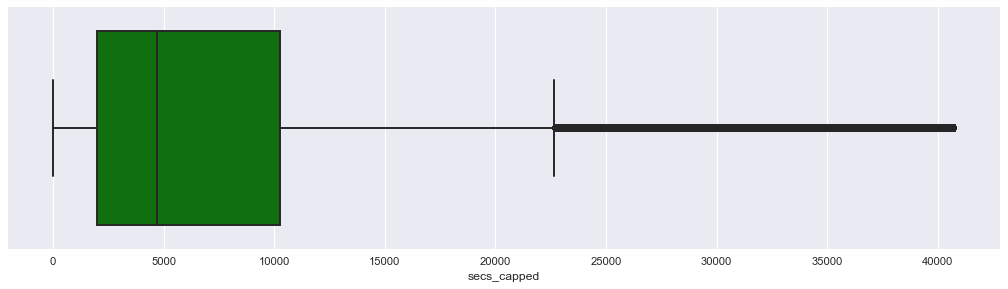

In [18]:
plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.boxplot(ul['secs_capped'], color='green')

In [19]:
ul['avg_song'] = ul['total_secs']/(((0.25*ul['num_25'] + 0.50*ul['num_50'] + 0.75*ul['num_75'] + 0.985*ul['num_985'])*0.90)+ul['num_100'])

In [33]:
print ('quantile 2.5% avg_song uncapped: {0}s' .format(ul['avg_song'].quantile(0.025)))
print ('quantile 50.0% avg_song uncapped: {0}s' .format(ul['avg_song'].quantile(0.50)))
print ('quantile 98.5% avg_song uncapped: {0}s' .format(ul['avg_song'].quantile(0.985)))

quantile 2.5% avg_song uncapped: 147.75330941807272s
quantile 50.0% avg_song uncapped: 235.15120515360087s
quantile 98.5% avg_song uncapped: 299.07188998270567s


/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


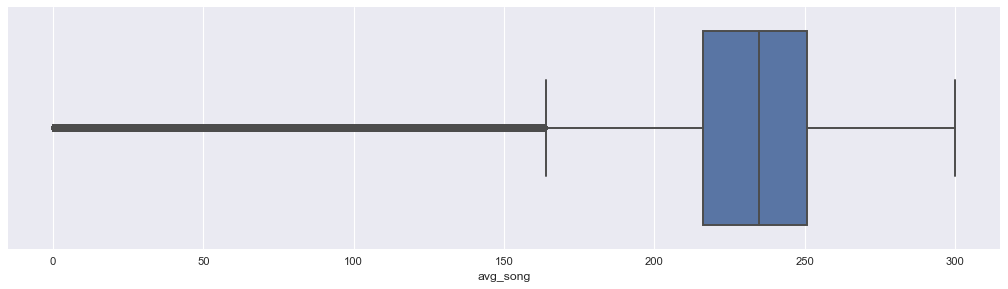

In [36]:
plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.boxplot(ul[(ul['avg_song']>0)&(ul['avg_song']<300)]['avg_song'])
#sns.boxplot(ul[(ul['avg_song']>0)&(ul['avg_song']<300)]['avg_song'])

In [37]:
avg_song = ul['avg_song'].quantile(0.5) #median

In [38]:
ul['total_secs_new'] = avg_song*(0.25*ul['num_25'] + 0.50*ul['num_50'] + 0.75*ul['num_75'] + 0.985*ul['num_985']+ul['num_100'])

In [39]:
ul['total_secs_new'].describe()

count    2.628684e+08
mean     8.244743e+03
std      1.016365e+04
min      5.878780e+01
25%      2.057573e+03
50%      4.879388e+03
75%      1.050891e+04
max      5.755502e+06
Name: total_secs_new, dtype: float64

In [47]:
ul['secs_capped_new'] = ul['total_secs_new'].clip(lower = 0, upper = ul['total_secs_new'].quantile(0.985))

In [48]:
ul['secs_diff'] = ul['secs_capped_new']-ul['secs_capped']

In [49]:
ul['secs_diff'].describe()

count    2.628684e+08
mean     1.059203e+02
std      1.319889e+03
min     -4.054138e+04
25%     -2.365808e+02
50%      3.259064e+01
75%      3.851083e+02
max      4.056358e+04
Name: secs_diff, dtype: float64

In [50]:
print ('quantile 2.5% secs_diff capped: {0}s' .format(ul['secs_diff'].quantile(0.025)))
print ('quantile 50.0% secs_diff capped: {0}s' .format(ul['secs_diff'].quantile(0.50)))
print ('quantile 98.5% secs_diff capped: {0}s' .format(ul['secs_diff'].quantile(0.985)))

quantile 2.5% secs_diff capped: -2143.9853471744746s
quantile 50.0% secs_diff capped: 32.590639386583916s
quantile 98.5% secs_diff capped: 3468.1195197297397s


/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


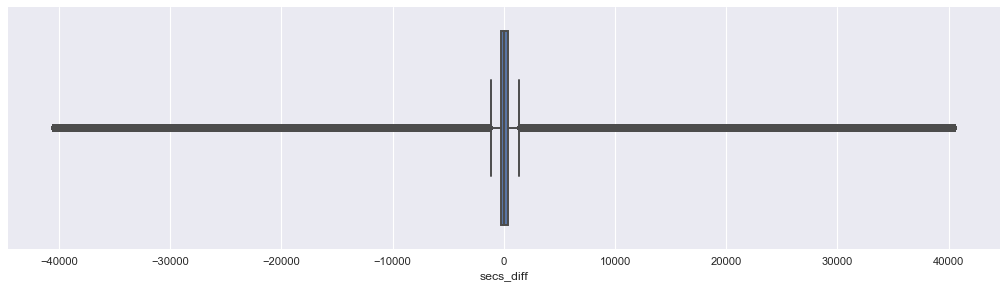

In [52]:
plt.figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
sns.boxplot(ul['secs_diff'])

In [54]:
ul['total_songs']=(0.25*ul['num_25'] + 0.50*ul['num_50'] + 0.75*ul['num_75'] + 0.985*ul['num_985']+ul['num_100'])

In [55]:
ul['total_songs'].describe()

count    2.628684e+08
mean     3.506145e+01
std      4.322178e+01
min      2.500000e-01
25%      8.750000e+00
50%      2.075000e+01
75%      4.469000e+01
max      2.447575e+04
Name: total_songs, dtype: float64

In [59]:
print ('quantile 2.5% total_songs uncapped: {0} songs' .format(ul['total_songs'].quantile(0.025)))
print ('quantile 50.0% total_songs uncapped: {0} songs' .format(ul['total_songs'].quantile(0.50)))
print ('quantile 98.5% total_songs uncapped: {0} songs' .format(ul['total_songs'].quantile(0.985)))
print ('quantile 99.5% total_songs uncapped: {0} songs' .format(ul['total_songs'].quantile(0.995)))

quantile 2.5% total_songs uncapped: 1.0 songs
quantile 50.0% total_songs uncapped: 20.75 songs
quantile 98.5% total_songs uncapped: 172.5 songs
quantile 99.5% total_songs uncapped: 220.0 songs


In [65]:
np.max(ul['total_songs'])

220.0

In [64]:
ul['total_songs'] = ul['total_songs'].clip(lower = 0, upper = ul['total_songs'].quantile(0.995))

In [63]:
#len(ul[ul['total_songs']>220])

/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/calestini/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


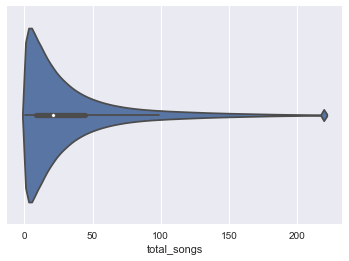

In [66]:
sns.violinplot(ul['total_songs'])

In [2]:
tmonths = pd.read_csv('ul_tsecs_month_mean.csv')

In [3]:
tmonths.head()

,new_id,2015001,2015002,2015003,2015004,2015005,2015006,2015007,2015008,2015009,...,2016005,2016006,2016007,2016008,2016009,2016010,2016011,2016012,2017001,2017002
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9911.205078,8284.257812,5262.289062,5797.553711
1,1,1873.203125,6028.793457,3056.291992,2895.172852,2780.402100,1000.655273,1236.438110,1505.682251,14764.951172,...,10022.055664,5384.766602,4464.692871,6172.605469,6193.244141,6357.543945,4597.857422,4999.303223,6390.493164,6750.280273
2,2,21673.003906,27191.789062,21275.046875,19340.996094,17118.615234,11813.696289,11428.293945,6830.270996,7854.643555,...,10452.239258,7977.053223,4837.768066,4197.290039,6567.140625,8956.428711,17024.890625,7045.274902,7991.004883,6188.441895
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3893.915527,5826.351074,2902.727783,2607.057861,7574.272949,4741.559570,4976.264648,5106.366699,3927.523682,3154.527588
4,4,2925.529297,8068.850586,5994.847168,4704.868652,1799.078857,2563.114258,4798.882812,2272.990723,4145.972168,...,4952.709961,3092.810059,2734.225098,1994.281250,1577.735107,1918.580811,1548.955444,3014.203369,1916.974609,2734.396973


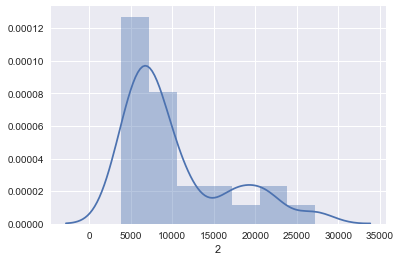

In [7]:
sns.distplot(tmonths.drop('new_id', axis = 1).loc[2,:])

In [8]:
total1 = np.sum(tmonths, axis = 1)
total0 = np.sum(tmonths, axis = 0)

In [9]:
total1.head()

0     29255.305664
1    153578.580566
2    266215.317139
3     59940.681152
4     86304.234741
dtype: float64

In [10]:
total0.head()

new_id     5.140408e+11
2015001    3.082980e+09
2015002    2.871399e+09
2015003   -1.006900e+15
2015004   -3.293763e+17
dtype: float64

In [11]:
tmonths[tmonths['2015003']<0]

,new_id,2015001,2015002,2015003,2015004,2015005,2015006,2015007,2015008,2015009,...,2016005,2016006,2016007,2016008,2016009,2016010,2016011,2016012,2017001,2017002
140759,160449,36724.437500,31509.539062,-3.074457e+14,13827.956055,19012.427734,13707.846680,1.716896e+04,-8.925845e+14,2.103173e+04,...,3167.019287,4327.035645,6840.060547,4927.621094,4026.118652,15047.892578,19431.183594,22229.691406,30352.802734,30506.623047
463584,527676,6922.263672,8250.390625,-3.074457e+14,4829.069824,5297.997559,6487.545410,-5.950563e+14,1.596850e+04,-3.074457e+14,...,1249.121826,1781.466675,2743.644775,14751.120117,3423.323486,5447.212891,6203.778809,6196.270996,12582.500977,7215.349609
790695,900398,7609.417480,6481.878906,-4.392082e+14,8248.444336,4821.947754,6290.920898,5.590473e+03,4.081413e+03,2.720711e+03,...,12503.665039,13536.093750,17327.666016,16965.275391,17790.667969,6193.926270,6947.958496,12808.844727,6128.481934,6119.767090


In [12]:
tsmonths = pd.read_csv('ul_tsecs_month.csv')

In [13]:
total0 = np.sum(tmonths, axis = 0)
total0.head()

new_id     5.140408e+11
2015001    3.082980e+09
2015002    2.871399e+09
2015003   -1.006900e+15
2015004   -3.293763e+17
dtype: float64